In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load the dataset

path_to_dataset = 'FinalData.csv'
try:
    import google.colab
    from google.colab import drive
    drive.mount('/content/drive')

    #CHANGE THIS
    colab_path = "/content/drive/MyDrive/Colab Notebooks/NTU_DA/"
    path_to_dataset = colab_path + path_to_dataset

    IN_COLAB = True
except:
    IN_COLAB = False

df = pd.read_csv(path_to_dataset, parse_dates=True)
df["day_in_a_week"] = pd.to_datetime(df["datetime"]).dt.dayofweek #Get the day in a week
df["month"] = pd.to_datetime(df["datetime"]).dt.month #Get month

## Removing unnecessary features

df = df.drop('datetime', axis=1) #We remove the date
df = df.drop("day", axis = 1) #We remove the day
df = df.drop("next_dist", axis = 1)
df = df.drop("bus_cnt", axis = 1)
df = df.drop("bike_cnt", axis = 1)
df = df.drop("school_cnt", axis = 1)

In [2]:
#Dataset information
# categorical_variables = ["mrt_station", "hour", "day", "status", "day_in_a_week", "month"]
categorical_variables = ["mrt_station", "hour", "status", "day_in_a_week", "month"]

y_ind = df.columns.get_loc("mrt_flow")
cat_indices = [df.columns.get_loc(categorical_variables[i]) for i in range(len(categorical_variables))]
real_indices = [i for i in list(range(0, len(df.columns))) if (i not in cat_indices and i != y_ind)]
print("metro_flow index: ", y_ind, "\ncategorical indices: ", cat_indices, "\nnumerical indices: ", real_indices)


unique_station_names = list(dict.fromkeys([df["mrt_station"][i] for i in range(len(df))]))
unique_status        = list(dict.fromkeys([df["status"][i] for i in range(len(df))]))
print("\n")
category_cnt = 0
for var in categorical_variables:
    unique_vals = list(dict.fromkeys([df[var][i] for i in range(len(df))]))
    print(str(len(unique_vals)) + " unique " + var + ":\t", unique_vals)
    category_cnt += len(unique_vals)


metro_flow index:  1 
categorical indices:  [0, 2, 10, 26, 27] 
numerical indices:  [3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


7 unique mrt_station:	 ['中山', '北投', '北門', '古亭', '士林', '大橋頭', '松山']
24 unique hour:	 [0, 1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 2, 3, 4]
5 unique status:	 ['良好', '普通', '對敏感族群不健康', nan, '對所有族群不健康']
7 unique day_in_a_week:	 [2, 3, 4, 5, 6, 0, 1]
12 unique month:	 [6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5]


In [3]:
import sklearn.model_selection
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.compose
import sklearn.linear_model

data = df.to_numpy()


#Convert station names to ints
print("Processing station names")
for i in range(len(unique_station_names)):
    print("\tFirst occurance of " + unique_station_names[i] + ":", np.nonzero(data == unique_station_names[i])[0][0])
    data[data == unique_station_names[i]] = i

print("\nProcessing station status")
#Convert status names to ints
for i in range(len(unique_status)):
    occurances = np.nonzero(data == unique_status[i])[0]
    if len(occurances) > 0:
        print("\tFirst occurance of " + str(unique_status[i]) + ":", occurances[0])
    data[data == unique_status[i]] = i

#Replace missing values with NaNs
data[data == "-"] = np.nan

##Train test split
train_split_ratio = 0.7
val_split_ratio = 0.1
test_split_ratio = 0.2

sample_cnt = data.shape[0]
train_sz = int(train_split_ratio * sample_cnt)
val_sz = int(val_split_ratio * sample_cnt)
test_sz = int(test_split_ratio * sample_cnt)

val_ind = train_sz + val_sz
test_ind = val_ind + test_sz

print("\nTrain-val-test split")
print("\tTrain start index:", 0)
print("\tVal start index:", train_sz)
print("\tTest start index:", val_ind)

Y_train_raw = data[:train_sz, y_ind][:, None]
X_train_raw = data[:train_sz, cat_indices + real_indices]

Y_val_raw = data[train_sz:val_ind, y_ind][:, None]
X_val_raw = data[train_sz:val_ind, cat_indices + real_indices]

Y_test_raw = data[val_ind:test_ind, y_ind][:, None]
X_test_raw = data[val_ind:test_ind, cat_indices + real_indices]

##Preprocessing
new_cat_indices = list(range(len(cat_indices)))
new_real_indices = list(range(len(cat_indices), len(cat_indices) + len(real_indices)))

#One hot encoding for categories, Robust scaling for numerical values
X_preprocessor = sklearn.compose.ColumnTransformer(
    transformers=[
        ("cat", sklearn.preprocessing.OneHotEncoder(categories='auto', handle_unknown="ignore"), new_cat_indices),
        ("num", sklearn.preprocessing.RobustScaler(), new_real_indices)
    ]
)
X_preprocessor.fit(X_train_raw)
X_train = X_preprocessor.transform(X_train_raw)
X_val   = X_preprocessor.transform(X_val_raw)
X_test  = X_preprocessor.transform(X_test_raw)

Processing station names
	First occurance of 中山: 0
	First occurance of 北投: 1
	First occurance of 北門: 2
	First occurance of 古亭: 3
	First occurance of 士林: 4
	First occurance of 大橋頭: 5
	First occurance of 松山: 6

Processing station status
	First occurance of 良好: 0
	First occurance of 普通: 54
	First occurance of 對敏感族群不健康: 7556
	First occurance of 對所有族群不健康: 15096

Train-val-test split
	Train start index: 0
	Val start index: 52361
	Test start index: 59841


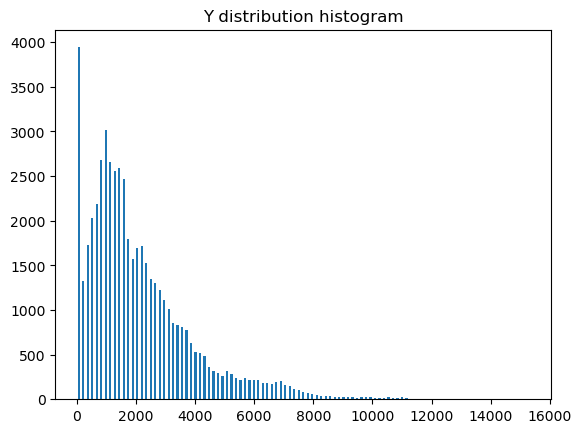

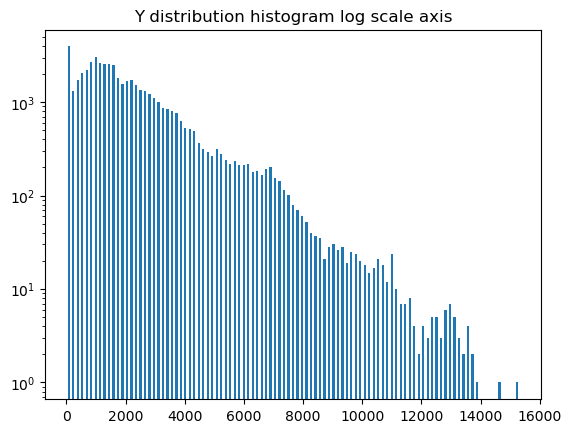

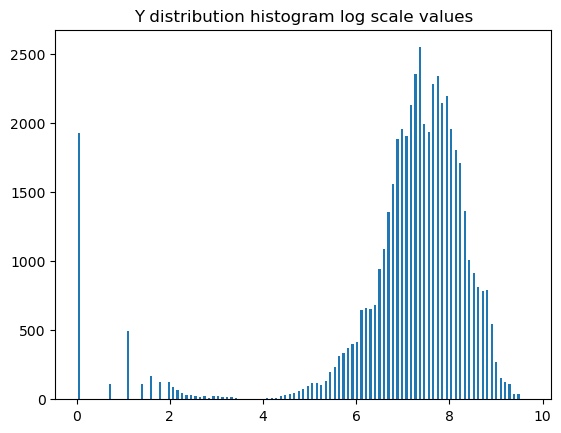

0.0 9.627140989748092


In [4]:
step = Y_train_raw.max() / 100
e = 0.00001
bins = np.arange(Y_train_raw.min() - e, Y_train_raw.max() + step, step)

plt.hist(Y_train_raw, bins=bins, rwidth = 0.5)
plt.title("Y distribution histogram")
plt.show()

plt.hist(Y_train_raw, bins=bins, rwidth = 0.5)
plt.gca().set_yscale('log')
plt.title("Y distribution histogram log scale axis")
plt.show()

Y_train_raw_mod = np.log(Y_train_raw.astype(float) + 1)
step = Y_train_raw_mod.max() / 100
bins = np.arange(Y_train_raw_mod.min() - e, Y_train_raw_mod.max() + step, step)
plt.hist(Y_train_raw_mod, bins=bins, rwidth = 0.5)
plt.title("Y distribution histogram log scale values")
plt.show()

## Transforming Y
# Y_scaler = sklearn.preprocessing.RobustScaler().fit(Y_train_raw)
# Y_train = Y_scaler.transform(Y_train_raw)
# Y_val   = Y_scaler.transform(Y_val_raw)
# Y_test  = Y_scaler.transform(Y_test_raw)

# def Y_inverse_transform(Y):
#     return Y_scaler.inverse_transform(Y)

#We apply log scaling for Y
Y_train_raw_log = np.log(Y_train_raw.astype(float) + 1)
Y_val_raw_log   = np.log(Y_val_raw.astype(float) + 1)
Y_test_raw_log  = np.log(Y_test_raw.astype(float) + 1)

print(Y_train_raw_log.min(), Y_train_raw_log.max())

#Robust scaling for Y
Y_scaler = sklearn.preprocessing.RobustScaler().fit(Y_train_raw_log)
Y_train = Y_scaler.transform(Y_train_raw_log)
Y_val   = Y_scaler.transform(Y_val_raw_log)
Y_test  = Y_scaler.transform(Y_test_raw_log)

def Y_inverse_transform(Y):
  return np.exp(Y_scaler.inverse_transform(Y)) - 1

#Replace NaNs with zeros
X_train[np.isnan(X_train)] = 0
X_val[np.isnan(X_val)] = 0
X_test[np.isnan(X_test)] = 0

# Sklearn Linear Regression

In [5]:
LR = sklearn.linear_model.LinearRegression(n_jobs=-1).fit(X_train, Y_train)

def print_metrics(X, Y):
    Y_hat = LR.predict(X)

    MSE = np.mean((Y_hat - Y) ** 2)
    orig_MSE = np.mean((Y_inverse_transform(Y_hat) - Y_inverse_transform(Y)) ** 2)
    print("\tMSE:", MSE)
    print("\tOriginal scale MSE:", orig_MSE)

    print("\n\tRMSE:", np.sqrt(MSE))
    print("\tOriginal scale RMSE:", np.sqrt(orig_MSE))

    print("\n\tMAE:", np.mean(np.abs(Y_hat - Y)))
    print("\tOriginal scale MAE:", np.mean(np.abs(Y_inverse_transform(Y_hat) - Y_inverse_transform(Y))))

print("Train metrics:")
print_metrics(X_train, Y_train)
print("\nValidation metrics:")
print_metrics(X_val, Y_val)
print("\nTest metrics:")
print_metrics(X_test, Y_test)

# removed_variables = []
# for i in range(1, X_train.shape[1]):
    
#     x_vars = [ii for ii in range(X_train.shape[1]) if ii != i and ii not in removed_variables]
#     LR = sklearn.linear_model.LinearRegression(n_jobs=-1).fit(X_train[:, x_vars], X_train[:, i])

#     tol = 1e-2
#     MSE = np.mean((LR.predict(X_train[:, x_vars]) - X_train[:, i]) ** 2 )
#     print("{} MSE:{}".format(i, MSE))
#     if tol > MSE:
#         removed_variables.append(i)

Train metrics:
	MSE: 0.38819475266092557
	Original scale MSE: 1005953.1603771579

	RMSE: 0.6230527687611424
	Original scale RMSE: 1002.9721633112047

	MAE: 0.3073685762439636
	Original scale MAE: 550.1100628084489

Validation metrics:
	MSE: 0.36143982410371134
	Original scale MSE: 1067258.4117989265

	RMSE: 0.6011986561060423
	Original scale RMSE: 1033.0819966483427

	MAE: 0.3024708581030118
	Original scale MAE: 585.4249554658733

Test metrics:
	MSE: 0.435867887141158
	Original scale MSE: 1118313.4733240781

	RMSE: 0.6602029136115335
	Original scale RMSE: 1057.503415277737

	MAE: 0.31979012465179874
	Original scale MAE: 623.1473562597739


# Sklearn MLP

In [6]:
from sklearn.neural_network import MLPRegressor

MLP = MLPRegressor(max_iter=2000, hidden_layer_sizes = (1000)).fit(X_train, np.ravel(Y_train))

def print_metrics(X, Y):
    Y_hat = MLP.predict(X)[:, None]

    MSE = np.mean((Y_hat - Y) ** 2)
    orig_MSE = np.mean((Y_inverse_transform(Y_hat) - Y_inverse_transform(Y)) ** 2)
    print("\tMSE:", MSE)
    print("\tOriginal scale MSE:", orig_MSE)

    print("\n\tRMSE:", np.sqrt(MSE))
    print("\tOriginal scale RMSE:", np.sqrt(orig_MSE))

    print("\n\tMAE:", np.mean(np.abs(Y_hat - Y)))
    print("\tOriginal scale MAE:", np.mean(np.abs(Y_inverse_transform(Y_hat) - Y_inverse_transform(Y))))

print("Train metrics:")
print_metrics(X_train, Y_train)
print("\nValidation metrics:")
print_metrics(X_val, Y_val)
print("\nTest metrics:")
print_metrics(X_test, Y_test)

Train metrics:
	MSE: 0.18393495040294738
	Original scale MSE: 244554.10365939676

	RMSE: 0.42887638126032
	Original scale RMSE: 494.52411837987916

	MAE: 0.1676900330214986
	Original scale MAE: 239.70690548650643

Validation metrics:
	MSE: 0.5202588237603395
	Original scale MSE: 6499166.358073777

	RMSE: 0.721289694755401
	Original scale RMSE: 2549.346260921371

	MAE: 0.37215390828573564
	Original scale MAE: 1069.4537416719525

Test metrics:
	MSE: 0.6726611996397268
	Original scale MSE: 9735680.532871874

	RMSE: 0.8201592526087399
	Original scale RMSE: 3120.2052068528883

	MAE: 0.4282166481332888
	Original scale MAE: 1233.2065923069592


# PyTorch initialization

In [7]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import copy
import time

default_dtype = torch.float32
torch.set_default_dtype(default_dtype)

#Initialize PyTorch
USE_CUDA = True

cuda_available = torch.cuda.is_available()
print("Cuda available: ", cuda_available)
print("Using Cuda: ", USE_CUDA)

if cuda_available:
  # print(torch.cuda.current_device())
  # print(torch.cuda.device_count())
  print(torch.cuda.get_device_name(0))
  cuda_device = torch.device("cuda:0")

#Move the dataset to GPU
input_size = X_train.shape[1]
X_train_t = torch.from_numpy(X_train).to(dtype = default_dtype)
X_val_t   = torch.from_numpy(X_val  ).to(dtype = default_dtype)
X_test_t  = torch.from_numpy(X_test ).to(dtype = default_dtype)
Y_train_t = torch.from_numpy(Y_train).to(dtype = default_dtype)
Y_val_t   = torch.from_numpy(Y_val  ).to(dtype = default_dtype)
Y_test_t  = torch.from_numpy(Y_test ).to(dtype = default_dtype)

if USE_CUDA and cuda_available:
    X_train_t = X_train_t.cuda()
    X_val_t   = X_val_t.cuda()
    X_test_t  = X_test_t.cuda()
    Y_train_t = Y_train_t.cuda()
    Y_val_t   = Y_val_t.cuda()
    Y_test_t  = Y_test_t.cuda()

loss_functions = {
    'SmoothL1': F.smooth_l1_loss,
    'L1': F.l1_loss,
    'MSE': F.mse_loss
}

Cuda available:  True
Using Cuda:  True
NVIDIA GeForce RTX 4070


# PyTorch training implementation

In [77]:
##Initialize model weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    torch.nn.init.xavier_uniform_(layer_in.weight, gain=0.5)
    layer_in.bias.data.fill_(0.0)

## Turn data into sequences that can be used for training
def get_batch_sequences(batch_idx, batch_size, permutation, X, Y):
    sample_sz = X.shape[0]

    batch_start = batch_idx * batch_size
    batch_end   = min(sample_sz, (batch_idx + 1) * batch_size)
    actual_size = batch_end - batch_start

    batch_indeces = permutation[batch_start:batch_end]
    batch_target = Y[batch_indeces]
    batch_data = X[batch_indeces]

    return [batch_data, batch_target, actual_size]

## Training step
def train(epoch, model, optimizer, scheduler, X, Y, batch_size, loss_fnc, print_mode, schedule):
    model.train()

    sample_sz = X.shape[0]
    perm = np.random.permutation(sample_sz)

    total_loss = 0
    for batch_idx in range(0, int(np.ceil(sample_sz / batch_size))):
        batch_data, batch_target, actual_size = get_batch_sequences(batch_idx, batch_size, perm, X, Y)
        optimizer.zero_grad()

        output = model(batch_data)
        loss = loss_fnc(output, batch_target, reduction="mean")
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        if schedule:
            scheduler.step()
        if print_mode:
            print('Epoch:{} \tTrain loss: {:.7f}'.format(epoch, total_loss / (batch_idx + 1)), end="\r")

    total_loss /= np.ceil(sample_sz / batch_size)
    if not print_mode:
        print('Epoch:{} \tTrain loss: {:.7f}'.format(epoch, total_loss), end="\r")

    return total_loss

## Testing
def test(model, X, Y, batch_size, loss_fnc):
    model.eval()
    test_loss = 0

    sample_sz = X.shape[0]
    with torch.no_grad():
        perm = np.random.permutation(sample_sz)

        for batch_idx in range(0, int(np.ceil(sample_sz / batch_size))):
            batch_data, batch_target, actual_size = get_batch_sequences(batch_idx, batch_size, perm, X, Y)

            output = model(batch_data)
            test_loss += loss_fnc(output, batch_target, reduction="mean").item()

    test_loss /= np.ceil(sample_sz / batch_size)
    return test_loss

def predict(model, X, batch_size):
    model.eval()
    test_loss = 0

    sample_sz = X.shape[0]
    Y_dummy = np.zeros((sample_sz, 1))
    Y_hat = np.zeros((sample_sz, 1))

    with torch.no_grad():
        perm = np.arange(0, sample_sz)

        for batch_idx in range(0, int(np.ceil(sample_sz / batch_size))):
            batch_data, batch_target, actual_size = get_batch_sequences(batch_idx, batch_size, perm, X, Y_dummy)

            output = model(batch_data)

            start_idx = batch_idx * batch_size
            end_idx = start_idx + actual_size

            Y_hat[start_idx:end_idx] = output[:].cpu()

    return Y_hat

# Training and Grid search procedures

In [139]:
## The whole training
def train_model(model_class, params, max_batch_size, print_mode):
    model = model_class(params)
    loss_fnc = loss_functions[params["loss"]]
    epochs = params["epochs"]
    lr = params["lr"]
    batch_size = params["batch_size"]
    weight_decay = params["weight_decay"]
    batch_growth = params["batch_growth"]


    if USE_CUDA and cuda_available:
      model = model.cuda()
    model.apply(weights_init)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    start_time = time.time()

    # Get initial performance
    test_loss = test(model, X_val_t, Y_val_t, batch_size, loss_functions[params["loss"]])
    if print_mode:
        print('\nInitial: Test loss: {:.7f}\n'.format(test_loss))

    # Train
    train_loss = None
    train_losses = []
    val_losses = []

    scheduler_steps = int(epochs * np.ceil(X_train_t.shape[0] / batch_size))
    if batch_growth:
        scheduler_steps = int((epochs // 2) * np.ceil(X_train_t.shape[0] / max_batch_size))
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=scheduler_steps, eta_min=0) #Cosine decay

    batch_increase_range = epochs - epochs // 2
    batch_increase_step_sz = batch_increase_range / np.log2(max_batch_size / batch_size)
    
    for epoch in range(1, epochs + 1):
        schedule = (epoch > np.ceil(batch_increase_range)) or (not batch_growth)
        current_batch_size = batch_size
        if batch_growth:
            current_batch_size = np.round(batch_size * np.power(2, (epoch - 1) // batch_increase_step_sz))
            current_batch_size = int(min(current_batch_size, max_batch_size))
        train_loss = train(epoch, model, optimizer, scheduler, X_train_t, Y_train_t, current_batch_size, loss_fnc, print_mode, schedule)

        if print_mode:
            # train_loss = test(model, X_train_t, Y_train_t, batch_size, loss_fnc)
            val_loss   = test(model, X_val_t, Y_val_t, batch_size, loss_fnc)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            # print('Epoch:' + str(epoch) + ' \tbatch size: {} \t LR: {}'.format(current_batch_size, optimizer.param_groups[0]['lr']))
            print('Epoch:' + str(epoch) + ' \tTrain loss: {:.7f} \tVal loss: {:.7f}'.format(train_loss, val_loss) + ' \tbatch size: {} \t LR: {}'.format(current_batch_size, optimizer.param_groups[0]['lr']))

    final_val_loss = test(model, X_val_t, Y_val_t, batch_size, loss_fnc)
    print("\nTime to train: {:.3f}s\t final train loss:{:.7f}\t final val loss:{:.7f}".format(time.time() - start_time, train_loss, final_val_loss))

    if print_mode:
        return [model, train_losses, val_losses]
    else:
        return [model, train_loss, final_val_loss]

## Grid search
def grid_search(model_class, param_variations, max_batch_size):
    best_val_loss = float("inf")
    best_train_loss = float("inf")
    best_val_params = None
    best_train_params = None

    val_losses = []
    train_losses = []

    for i in range(len(param_variations)):
        params = param_variations[i]
        print("\nGrid search step {}/{}".format(i + 1, len(param_variations)), "\t| params:", params)

        model, train_loss, val_loss = train_model(model_class, params, max_batch_size, print_mode=False)

        if best_train_loss > train_loss:
            print("New train best!")
            best_train_loss = train_loss
            best_train_params = params
            
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if best_val_loss > val_loss:
            print("New val best!")
            best_val_loss = val_loss
            best_val_params = params
            

    print("\nBest validation loss: ", best_val_loss)
    print("\nBest training loss: ", best_train_loss)
    print("Best val params: ", best_val_params)
    print("Best train params: ", best_train_params)
    # model, train_losses, val_losses = train_model(model_class, best_params, print_mode=True)
    return [best_train_params, best_val_params, train_losses, val_losses]

## Create list of parameter dictionaries for grid search
def create_param_dict_from_lists(list_of_params, list_of_names):
    params = []

    feature_vals = list_of_params[0]
    feature_name = list_of_names[0]
    for feature_val in feature_vals:
        params_row = {}
        params_row[feature_name] = feature_val
        params.append(params_row)

    for i in range(1, len(list_of_params)):
        feature_vals = list_of_params[i]
        feature_name = list_of_names[i]

        old_params = params
        new_params = []
        for past_param in old_params:
            for feature_val in feature_vals:
                params_row = copy.copy(past_param)
                params_row[feature_name] = feature_val
                new_params.append(params_row)
        params = new_params

    return params

## Grid search plotting
def plot_grid(grid_values, title, x_label, y_label, x_values, y_values):
    plt.matshow(grid_values)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.colorbar()
    plt.xticks(list(range(len(x_values))), x_values)
    plt.yticks(list(range(len(y_values))), y_values)

    for (i, j), z in np.ndenumerate(grid_values):
        plt.text(j, i, '{:0.5f}'.format(z), ha='center', va='center')

    plt.show()

## Plot training progress
def plot_losses(train_losses, val_losses, title):
    plt.title(title)
    plt.plot(train_losses, label="train loss")
    plt.plot(val_losses, label="val loss")
    plt.xlabel("epochs")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()

## Evaluation
def evaluate_model(model, batch_size):
    def print_metrics(model, X, Y, batch_size):
        Y_hat = predict(model, X, batch_size)

        MSE = np.mean((Y_hat - Y) ** 2)
        orig_MSE = np.mean((Y_inverse_transform(Y_hat) - Y_inverse_transform(Y)) ** 2)
        print("\tMSE:", MSE)
        print("\tOriginal scale MSE:", orig_MSE)

        print("\n\tRMSE:", np.sqrt(MSE))
        print("\tOriginal scale RMSE:", np.sqrt(orig_MSE))

        print("\n\tMAE:", np.mean(np.abs(Y_hat - Y)))
        print("\tOriginal scale MAE:", np.mean(np.abs(Y_inverse_transform(Y_hat) - Y_inverse_transform(Y))))

    print("Train metrics:")
    print_metrics(model, X_train_t, Y_train, batch_size)
    print("\nValidation metrics:")
    print_metrics(model, X_val_t, Y_val, batch_size)
    print("\nTest metrics:")
    print_metrics(model, X_test_t, Y_test, batch_size)

## Learning Rate Range Test
def Learning_Rate_Range_Test(model_class, min_lr, max_lr, epochs, params):
    model = model_class(params)
    loss_fnc = loss_functions[params["loss"]]
    batch_size = params["batch_size"]
    weight_decay = params["weight_decay"]

    step_cnt = np.ceil(X_train_t.shape[0] / batch_size) * epochs
    gamma = np.power((max_lr/min_lr), 1/step_cnt)
    print("gamma per batch:", gamma)
    print("gamma per epoch:", np.power(gamma, np.ceil(X_train_t.shape[0] / batch_size)))
    print("residual:", np.abs(max_lr/min_lr - np.power(gamma, step_cnt)))

    if USE_CUDA and cuda_available:
      model = model.cuda()
    model.apply(weights_init)

    optimizer = optim.Adam(model.parameters(), lr=min_lr, weight_decay=weight_decay)

    start_time = time.time()

    # Get initial performance
    test_loss = test(model, X_train_t, Y_train_t, batch_size, loss_functions[params["loss"]])
    print('\nInitial: Train loss: {:.7f}\n'.format(test_loss))

    # Train
    train_loss = None
    train_losses = []
    learning_rates = []

    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma = gamma)
    for epoch in range(1, epochs + 1):
        train_loss = train(epoch, model, optimizer, scheduler, X_train_t, Y_train_t, batch_size, loss_fnc, True, True)
        learning_rates.append(optimizer.param_groups[0]['lr'])
        train_losses.append(train_loss)
        print('Epoch:' + str(epoch) + ' \tTrain loss: {:.7f} \tLR:'.format(train_loss), learning_rates[-1])

    print("\nTime to train: {:.3f}s".format(time.time() - start_time))

    train_losses = np.array(train_losses)
    learning_rates = np.array(learning_rates)
    best_lr = learning_rates[np.argmin(train_losses)]
    
    plt.plot(learning_rates, train_losses)
    plt.gca().set_xscale('log')
    plt.gca().set_yscale('log')
    plt.xlabel("learning rate")
    plt.ylabel("loss")
    plt.show()

    return [model, train_losses, learning_rates, best_lr]

## Get maximum batch size
def get_max_batch_size(model):
    max_batch_size = 2
    try:
        while max_batch_size < X_train_t.shape[0]:
            Y_train_hat = predict(model, X_train_t, max_batch_size)
            max_batch_size *= 2
        print("batch size of {} is larger than the dataset size!".format(max_batch_size))
    except:
        print("batch size of {} caused OOM!".format(max_batch_size))
    
    max_batch_size = int(max_batch_size / 4)
    print("max_batch_size:", max_batch_size)
    
    return max_batch_size

# PyTorch Linear Regression implementation

In [117]:
class Linear_Regression(nn.Module):
    def __init__(self, params):
        super(Linear_Regression, self).__init__()
        self.fc = nn.Linear(input_size, 1)

        self.p = params["dropout_rate"]
        if self.p != None:
            self.dropout = nn.Dropout(self.p)

    def forward(self, x):
        if self.p != None:
            x = self.dropout(x)
        x = self.fc(x)
        return x

gamma per batch: 1.000100244603846
gamma per epoch: 3.7144712429422952
residual: 6.003247108310461e-06

Initial: Train loss: 5.6793043

Epoch:1 	Train loss: 5.4275676 	LR: 3.714471242942304e-06
Epoch:2 	Train loss: 4.4622553 	LR: 1.3797296614645255e-05
Epoch:3 	Train loss: 2.5876612 	LR: 5.124966150544484e-05
Epoch:4 	Train loss: 1.4941478 	LR: 0.00019036539387249992
Epoch:5 	Train loss: 0.8154634 	LR: 0.0007071067811907841
Epoch:6 	Train loss: 0.4398233 	LR: 0.0026265278044226405
Epoch:7 	Train loss: 0.5459629 	LR: 0.009756161998316297
Epoch:8 	Train loss: 1.1778857 	LR: 0.03623898318423237
Epoch:9 	Train loss: 9.1421164 	LR: 0.13460866091130047
Epoch:10 	Train loss: 123.2094026 	LR: 0.5000000000059917

Time to train: 77.822s


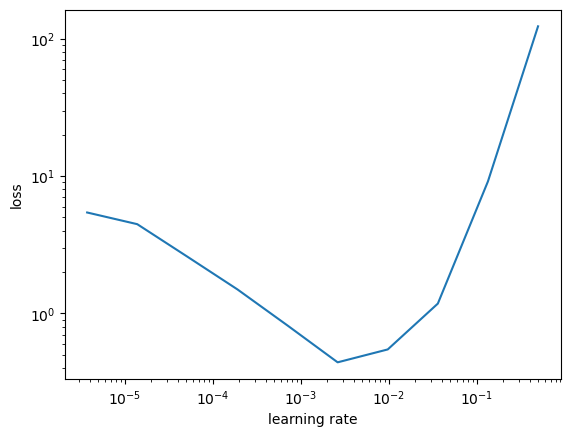

best_lr: 0.0026265278044226405
batch size of 65536 is larger than the dataset size!
max_batch_size: 32768


In [121]:
# Find the best initial learning rate
params = {'batch_size': 4, 'loss': 'MSE', 'weight_decay': 0, 'dropout_rate': None}
min_lr = 1e-6
max_lr = 5e-1
steps = 10

model, train_losses, learning_rates, best_lr_LR = Learning_Rate_Range_Test(Linear_Regression, min_lr, max_lr, steps, params)
print("best_lr:", best_lr_LR)

# Find the maximum batch size
max_batch_size_LR = get_max_batch_size(model)

# PyTorch Linear Regression training

In [122]:
# Parameters for grid search
epochs = [5, 10, 20, 50]
batch_size = [4]
dropout_rate = [None]
lrs = [best_lr_LR]
weight_decay = [0]
batch_growths = [True, False]
loss = ["MSE"]

# Parameter formatting
all_param_vals = [epochs, batch_size, lrs, batch_growths, loss, weight_decay, dropout_rate]
feature_names = ["epochs", "batch_size", "lr", "batch_growth", "loss", "weight_decay", "dropout_rate"]
params = create_param_dict_from_lists(all_param_vals, feature_names)

print("All grid searched values:")
for param in params:
    print("\t", param)

# Grid search
best_train_params_LR, best_val_params_LR, grid_train_losses_LR, grid_val_losses_LR = grid_search(Linear_Regression, params, max_batch_size_LR)

print("Final training for the min val loss:")
model_LR, train_losses_LR, val_losses_LR = train_model(Linear_Regression, best_val_params_LR, max_batch_size_LR, print_mode=True)

All grid searched values:
	 {'epochs': 10, 'batch_size': 4, 'lr': 0.0026265278044226405, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'dropout_rate': None}
	 {'epochs': 10, 'batch_size': 4, 'lr': 0.0026265278044226405, 'batch_growth': False, 'loss': 'MSE', 'weight_decay': 0, 'dropout_rate': None}
	 {'epochs': 20, 'batch_size': 4, 'lr': 0.0026265278044226405, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'dropout_rate': None}
	 {'epochs': 20, 'batch_size': 4, 'lr': 0.0026265278044226405, 'batch_growth': False, 'loss': 'MSE', 'weight_decay': 0, 'dropout_rate': None}

Grid search step 1/4 	| params: {'epochs': 10, 'batch_size': 4, 'lr': 0.0026265278044226405, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'dropout_rate': None}
Epoch:10 	Train loss: 0.3872982
Time to train: 8.365s	 final train loss:0.3872982	 final val loss:0.3608040
New val best!
New train best!

Grid search step 2/4 	| params: {'epochs': 10, 'batch_size': 4, 'lr': 0.0026265278044226405, 'bat

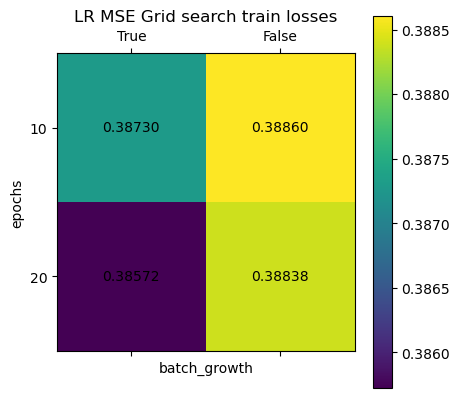

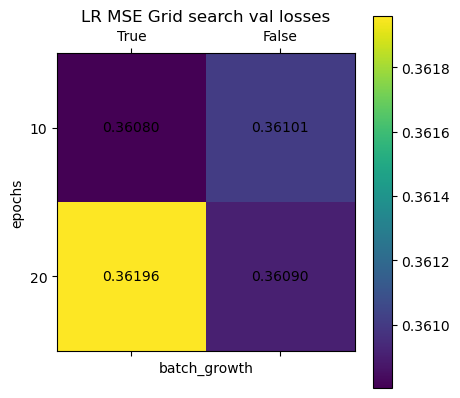

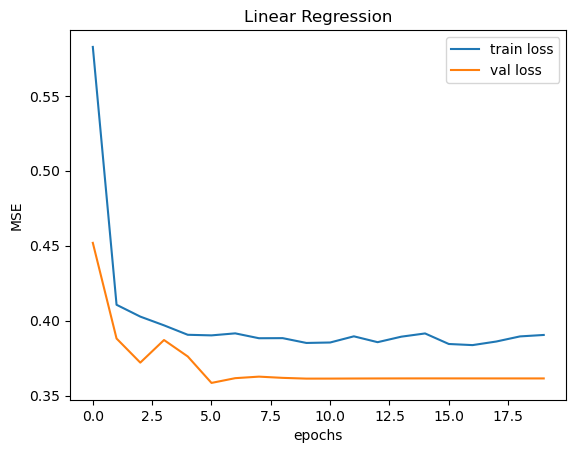

best train params:  {'epochs': 20, 'batch_size': 4, 'lr': 0.0026265278044226405, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'dropout_rate': None}
best val params:  {'epochs': 10, 'batch_size': 4, 'lr': 0.0026265278044226405, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'dropout_rate': None}
Train metrics:
	MSE: 0.3882499764314507
	Original scale MSE: 1003368.8150644569

	RMSE: 0.623097084274554
	Original scale RMSE: 1001.6829913023665

	MAE: 0.3071492979970198
	Original scale MAE: 549.4050502724992

Validation metrics:
	MSE: 0.36143284249046576
	Original scale MSE: 1070367.0219169795

	RMSE: 0.6011928496667819
	Original scale RMSE: 1034.5854348080586

	MAE: 0.30239769844419606
	Original scale MAE: 585.2218381437166

Test metrics:
	MSE: 0.4353746982676105
	Original scale MSE: 1115124.5645714626

	RMSE: 0.6598292947934417
	Original scale RMSE: 1055.9945854839705

	MAE: 0.3191894478302046
	Original scale MAE: 622.0543493577727


In [131]:
# Show grid search progress
train_grid = np.zeros((len(epochs), len(batch_growths)))
val_grid = np.zeros((len(epochs), len(batch_growths)))

for i in range(len(grid_val_losses_LR)):
    train_grid[i // len(batch_growths), i % len(batch_growths)] = grid_train_losses_LR[i]
    val_grid  [i // len(batch_growths), i % len(batch_growths)] = grid_val_losses_LR[i]

plot_grid(grid_values=train_grid, title="LR MSE Grid search train losses", x_label="batch_growth", y_label="epochs", x_values=batch_growths, y_values=epochs)
plot_grid(grid_values=val_grid  , title="LR MSE Grid search val losses"  , x_label="batch_growth", y_label="epochs", x_values=batch_growths, y_values=epochs)

# Plot the training progress
plot_losses(train_losses_LR, val_losses_LR, "Linear Regression")

# Show final model evaluation
print("best train params: ", best_train_params_LR)
print("best val params: ", best_val_params_LR)
evaluate_model(model_LR, max_batch_size_LR)

# PyTorch MLP implementation

In [132]:
class MLP_Regressor(nn.Module):
    def __init__(self, params):
        super(MLP_Regressor, self).__init__()

        self.hidden_size = params["hidden_size"]
        self.input_dropout_rate = params["input_dropout_rate"]
        self.hidden_dropout_rate = params["hidden_dropout_rate"]

        self.fc1 = nn.Linear(input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, 1)

        if self.input_dropout_rate != None:
            self.input_dropout = nn.Dropout(self.input_dropout_rate)
        if self.hidden_dropout_rate != None:
            self.hidden_dropout = nn.Dropout(self.hidden_dropout_rate)

    def forward(self, x):
        if self.input_dropout_rate != None:
            x = self.input_dropout(x)

        x = torch.relu(self.fc1(x))

        if self.hidden_dropout_rate != None:
            x = self.hidden_dropout(x)
        x = self.fc2(x)

        return x

gamma per batch: 1.000100244603846
gamma per epoch: 3.7144712429422952
residual: 6.003247108310461e-06

Initial: Train loss: 2.5514592

Epoch:1 	Train loss: 2.5120230 	LR: 3.714471242942273e-08
Epoch:2 	Train loss: 2.3787875 	LR: 1.379729661464517e-07
Epoch:3 	Train loss: 1.9938504 	LR: 5.124966150544435e-07
Epoch:4 	Train loss: 1.1705371 	LR: 1.9036539387249879e-06
Epoch:5 	Train loss: 0.4628141 	LR: 7.071067811907728e-06
Epoch:6 	Train loss: 0.4394461 	LR: 2.6265278044225888e-05
Epoch:7 	Train loss: 0.4612651 	LR: 9.756161998316115e-05
Epoch:8 	Train loss: 0.7926363 	LR: 0.00036238983184231656
Epoch:9 	Train loss: 18.2630163 	LR: 0.0013460866091129663
Epoch:10 	Train loss: 2155.0035358 	LR: 0.0050000000000598385

Time to train: 239.039s


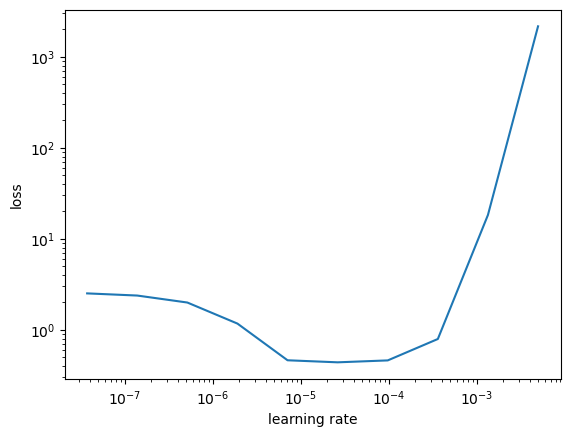

best_lr: 2.6265278044225888e-05
batch size of 16384 caused OOM!
max_batch_size: 8192


In [137]:
# Find the best initial learning rate
hidden_size = 100000

params = {'batch_size': 4, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': None, 'hidden_dropout_rate': None, 'hidden_size': hidden_size}
min_lr = 1e-8
max_lr = 5e-3
steps = 10

model, train_losses, learning_rates, best_lr_MLP = Learning_Rate_Range_Test(MLP_Regressor, min_lr, max_lr, steps, params)
print("best_lr:", best_lr_MLP)

# Find the maximum batch size
max_batch_size_MLP = get_max_batch_size(model)

# PyTorch MLP training optimization

In [143]:
# Parameters for grid search
epochs = [20, 50, 100, 200]
batch_size = [4]
loss = ["MSE"]
lrs = [best_lr_MLP]
weight_decay = [0]
batch_growths = [True, False]

input_dropout_rate = [None]
hidden_dropout_rate = [None]
hidden_sizes = [hidden_size]

# Parameter formatting
all_param_vals = [epochs, batch_size, lrs, batch_growths, loss, weight_decay, input_dropout_rate, hidden_dropout_rate, hidden_sizes]
feature_names = ["epochs", "batch_size", "lr", "batch_growth", "loss", "weight_decay", "input_dropout_rate", "hidden_dropout_rate", "hidden_size"]
params = create_param_dict_from_lists(all_param_vals, feature_names)

print("All grid searched values:\n")
for param in params:
    print(param)

# Grid search
best_train_params_MLP, best_val_params_MLP, grid_train_losses_MLP, grid_val_losses_MLP = grid_search(MLP_Regressor, params, max_batch_size_MLP)

print("Final training for the min train loss:")
model_MLP, train_losses_MLP, val_losses_MLP = train_model(MLP_Regressor, best_train_params_MLP, max_batch_size_MLP, print_mode=True)

All grid searched values:

{'epochs': 2, 'batch_size': 4, 'lr': 2.6265278044225888e-05, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': None, 'hidden_dropout_rate': None, 'hidden_size': 100000}
{'epochs': 2, 'batch_size': 4, 'lr': 2.6265278044225888e-05, 'batch_growth': False, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': None, 'hidden_dropout_rate': None, 'hidden_size': 100000}
{'epochs': 3, 'batch_size': 4, 'lr': 2.6265278044225888e-05, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': None, 'hidden_dropout_rate': None, 'hidden_size': 100000}
{'epochs': 3, 'batch_size': 4, 'lr': 2.6265278044225888e-05, 'batch_growth': False, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': None, 'hidden_dropout_rate': None, 'hidden_size': 100000}

Grid search step 1/4 	| params: {'epochs': 2, 'batch_size': 4, 'lr': 2.6265278044225888e-05, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': None, 'hidd

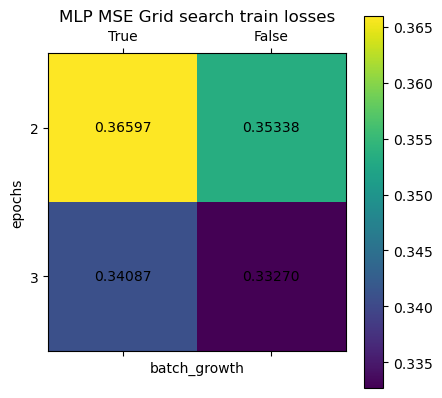

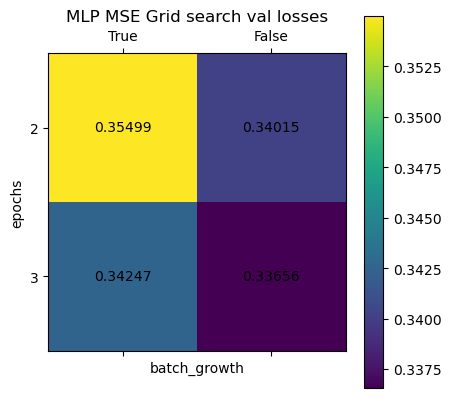

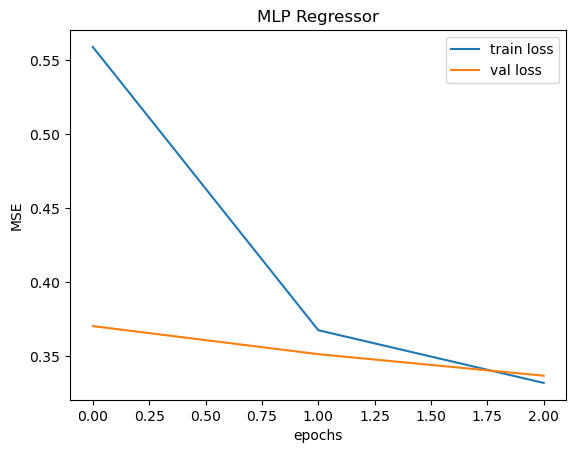

best train params:  {'epochs': 3, 'batch_size': 4, 'lr': 2.6265278044225888e-05, 'batch_growth': False, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': None, 'hidden_dropout_rate': None, 'hidden_size': 100000}
best val params:  {'epochs': 3, 'batch_size': 4, 'lr': 2.6265278044225888e-05, 'batch_growth': False, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': None, 'hidden_dropout_rate': None, 'hidden_size': 100000}
Train metrics:
	MSE: 0.3245399926746656
	Original scale MSE: 431562.75262588856

	RMSE: 0.5696841165722155
	Original scale RMSE: 656.934359449929

	MAE: 0.23220329321770766
	Original scale MAE: 360.4425638999162

Validation metrics:
	MSE: 0.33667841444353863
	Original scale MSE: 573384.8061250055

	RMSE: 0.5802399628115411
	Original scale RMSE: 757.2217681267526

	MAE: 0.24340318619392856
	Original scale MAE: 427.21476446931064

Test metrics:
	MSE: 0.42061949316237296
	Original scale MSE: 899621.5416695174

	RMSE: 0.6485518430799291
	Original scale RMSE: 948.4

In [144]:
# Show grid search progress
train_grid = np.zeros((len(epochs), len(batch_growths)))
val_grid = np.zeros((len(epochs), len(batch_growths)))

for i in range(len(grid_val_losses_MLP)):
    train_grid[i // len(batch_growths), i % len(batch_growths)] = grid_train_losses_MLP[i]
    val_grid  [i // len(batch_growths), i % len(batch_growths)] = grid_val_losses_MLP[i]

plot_grid(grid_values=train_grid, title="MLP MSE Grid search train losses", x_label="batch_growth", y_label="epochs", x_values=batch_growths, y_values=epochs)
plot_grid(grid_values=val_grid  , title="MLP MSE Grid search val losses"  , x_label="batch_growth", y_label="epochs", x_values=batch_growths, y_values=epochs)

# Plot the training progress
plot_losses(train_losses_MLP, val_losses_MLP, "MLP Regressor")

# Show final model evaluation
print("best train params: ", best_train_params_MLP)
print("best val params: ", best_val_params_MLP)
evaluate_model(model_MLP, max_batch_size_MLP)

# PyTorch MLP dropout optimization

In [145]:
# Parameters for grid search
epochs = [200]
batch_size = [4]
loss = ["MSE"]
lrs = [best_lr_MLP]
weight_decay = [0]
batch_growths = [True]

input_dropout_rate = [None, 0.2, 0.5]
hidden_dropout_rate = [None, 0.2, 0.5]
hidden_sizes = [hidden_size]

# Parameter formatting
all_param_vals = [epochs, batch_size, lrs, batch_growths, loss, weight_decay, input_dropout_rate, hidden_dropout_rate, hidden_sizes]
feature_names = ["epochs", "batch_size", "lr", "batch_growth", "loss", "weight_decay", "input_dropout_rate", "hidden_dropout_rate", "hidden_size"]
params = create_param_dict_from_lists(all_param_vals, feature_names)

print("All grid searched values:\n")
for param in params:
    print(param)

# Grid search
best_train_params_MLP, best_val_params_MLP, grid_train_losses_MLP, grid_val_losses_MLP = grid_search(MLP_Regressor, params, max_batch_size_MLP)

print("Final training for the min val loss:")
model_MLP, train_losses_MLP, val_losses_MLP = train_model(MLP_Regressor, best_val_params_MLP, max_batch_size_MLP, print_mode=True)

All grid searched values:

{'epochs': 5, 'batch_size': 4, 'lr': 2.6265278044225888e-05, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': None, 'hidden_dropout_rate': None, 'hidden_size': 100000}
{'epochs': 5, 'batch_size': 4, 'lr': 2.6265278044225888e-05, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': None, 'hidden_dropout_rate': 0.1, 'hidden_size': 100000}
{'epochs': 5, 'batch_size': 4, 'lr': 2.6265278044225888e-05, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': 0.1, 'hidden_dropout_rate': None, 'hidden_size': 100000}
{'epochs': 5, 'batch_size': 4, 'lr': 2.6265278044225888e-05, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': 0.1, 'hidden_dropout_rate': 0.1, 'hidden_size': 100000}

Grid search step 1/4 	| params: {'epochs': 5, 'batch_size': 4, 'lr': 2.6265278044225888e-05, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': None, 'hidden_dro

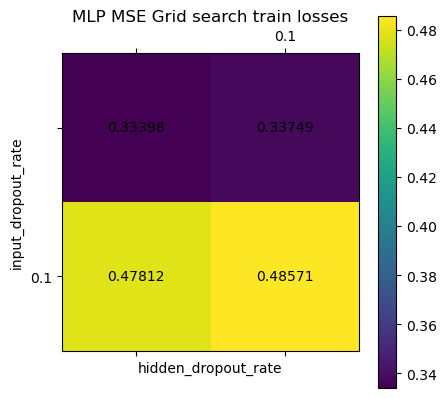

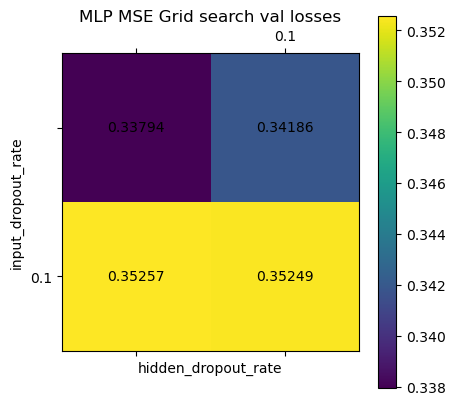

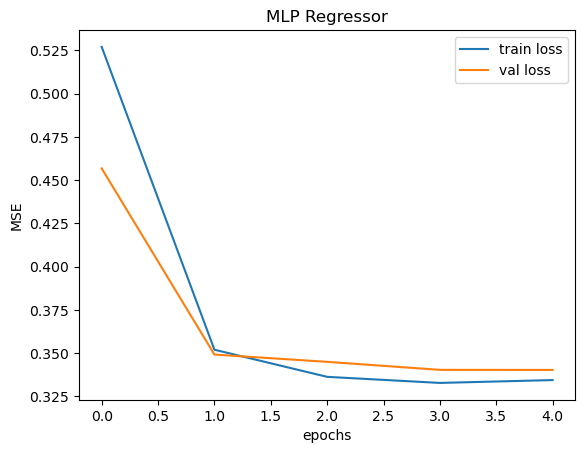

best train params:  {'epochs': 5, 'batch_size': 4, 'lr': 2.6265278044225888e-05, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': None, 'hidden_dropout_rate': None, 'hidden_size': 100000}
best val params:  {'epochs': 5, 'batch_size': 4, 'lr': 2.6265278044225888e-05, 'batch_growth': True, 'loss': 'MSE', 'weight_decay': 0, 'input_dropout_rate': None, 'hidden_dropout_rate': None, 'hidden_size': 100000}
Train metrics:
	MSE: 0.3328242193046181
	Original scale MSE: 500691.6537899548

	RMSE: 0.5769091950251947
	Original scale RMSE: 707.5956852539131

	MAE: 0.2447901676814045
	Original scale MAE: 390.4543679981061

Validation metrics:
	MSE: 0.3402642729750157
	Original scale MSE: 704009.8152667528

	RMSE: 0.5833217576732551
	Original scale RMSE: 839.052927571767

	MAE: 0.2634347162588132
	Original scale MAE: 483.2330916328253

Test metrics:
	MSE: 0.43117088393456227
	Original scale MSE: 1097288.3767657867

	RMSE: 0.6566360361224186
	Original scale RMSE: 1047.515334

In [146]:
# Show grid search progress
train_grid = np.zeros((len(input_dropout_rate), len(hidden_dropout_rate)))
val_grid = np.zeros((len(input_dropout_rate), len(hidden_dropout_rate)))

for i in range(len(grid_val_losses_MLP)):
    train_grid[i // len(hidden_dropout_rate), i % len(hidden_dropout_rate)] = grid_train_losses_MLP[i]
    val_grid  [i // len(hidden_dropout_rate), i % len(hidden_dropout_rate)] = grid_val_losses_MLP[i]

plot_grid(grid_values=train_grid, title="MLP MSE Grid search train losses", x_label="hidden_dropout_rate", y_label="input_dropout_rate", x_values=hidden_dropout_rate, y_values=input_dropout_rate)
plot_grid(grid_values=val_grid  , title="MLP MSE Grid search val losses"  , x_label="hidden_dropout_rate", y_label="input_dropout_rate", x_values=hidden_dropout_rate, y_values=input_dropout_rate)

# Plot the training progress
plot_losses(train_losses_MLP, val_losses_MLP, "MLP Regressor")

# Show final model evaluation
print("best train params: ", best_train_params_MLP)
print("best val params: ", best_val_params_MLP)
evaluate_model(model_MLP, max_batch_size_MLP)